In [25]:
import torch
import pandas as pd
import numpy as np
from models.Zilpzalp import Zilpzalp
from Datasets.static_dataset import SpectralDataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score

In [2]:
df_train = pd.read_csv('storage/df_train_local.csv')
ds_train = SpectralDataset(df_train)
df_test = pd.read_csv('storage/df_test_local.csv')
ds_test = SpectralDataset(df_test)
codes = pd.read_csv('storage/label_codes.csv')

In [5]:
model = Zilpzalp(128, 212, 10)
model.load_state_dict(torch.load('checkpoint.feca6871-acb7-4549-b1a0-86d474777c3a.tar')['state_dict'])

In [28]:
def predict(dataset, model):
    pred = []
    real = []
    for sample in dataset:
        p = model(torch.Tensor(sample[0]).unsqueeze(dim = 0))
        pred.append(np.argmax(p.detach().numpy()))
        real.append(sample[1])
    return pred, real

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt



This takes long:

In [34]:
pred_train, real_train = predict(ds_train, model)   

In [31]:
pred_test, real_test = predict(ds_test, model)   

Actual plotting:

In [ ]:
cnf_matrix_train = confusion_matrix(real_train, pred_train)
cnf_matrix_test = confusion_matrix(real_test, pred_test)

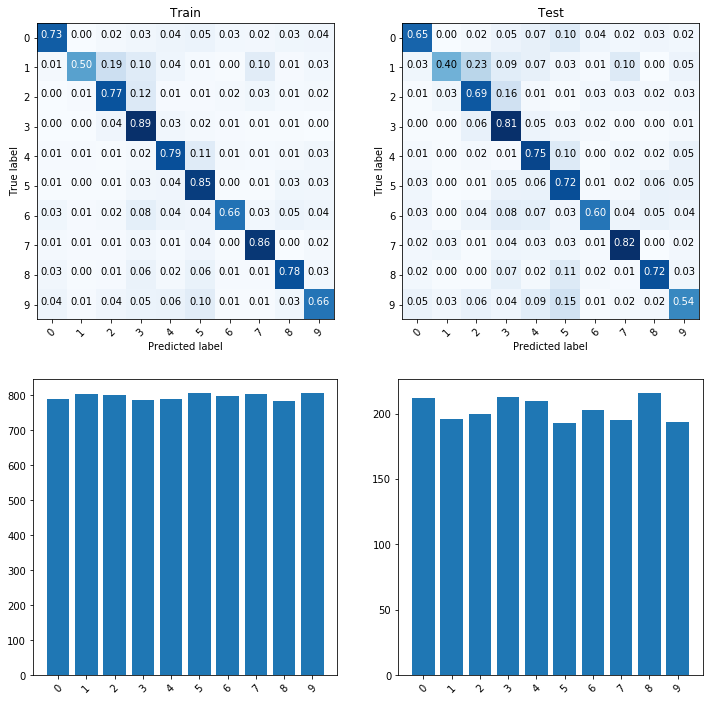

Train Acc:  0.7482429718875502 , Test Acc:  0.6707677165354331


In [69]:
plt.figure(figsize = (12, 12))
plt.title('Confusion Matrices and class distributions Train/Test')

plt.subplot(221)
plot_confusion_matrix(cnf_matrix_train, classes=list(range(10)), normalize=True,title='Train')

plt.subplot(222)
plot_confusion_matrix(cnf_matrix_test, classes=list(range(10)), normalize=True, title='Test')

plt.subplot(223)
unique, counts = np.unique(real_train, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, rotation=45)

plt.subplot(224)
unique, counts = np.unique(real_test, return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, rotation=45)
plt.show()
print('Train Acc: ', accuracy_score(real_train, pred_train), ', Test Acc: ', accuracy_score(real_test, pred_test))

In [83]:
import pickle
def load_examples(df, cl, no):
    def unpickle(path):
        with open(path, 'rb') as f:
            slice_ = pickle.load(f)
        return slice_
    sel = df[df.label == cl].sample(n= no)
    paths = sel.path
    slices = []
    for path in paths:
        slices.append(unpickle(path))
    return slices

In [117]:
def plot_examples(df, cl = 10, no = 5):
    fig, ax = plt.subplots(cl, no,figsize=(15,20))
    
    for i in range(cl):
        ex = load_examples(df, i, no)
        for j, img in enumerate(ex):
            ax[i, j].imshow(img, cmap = 'jet')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        ax[i, 0].set_ylabel(f'Class: {i}', rotation=90, size = 'large')
        
    plt.tight_layout()
    plt.show()

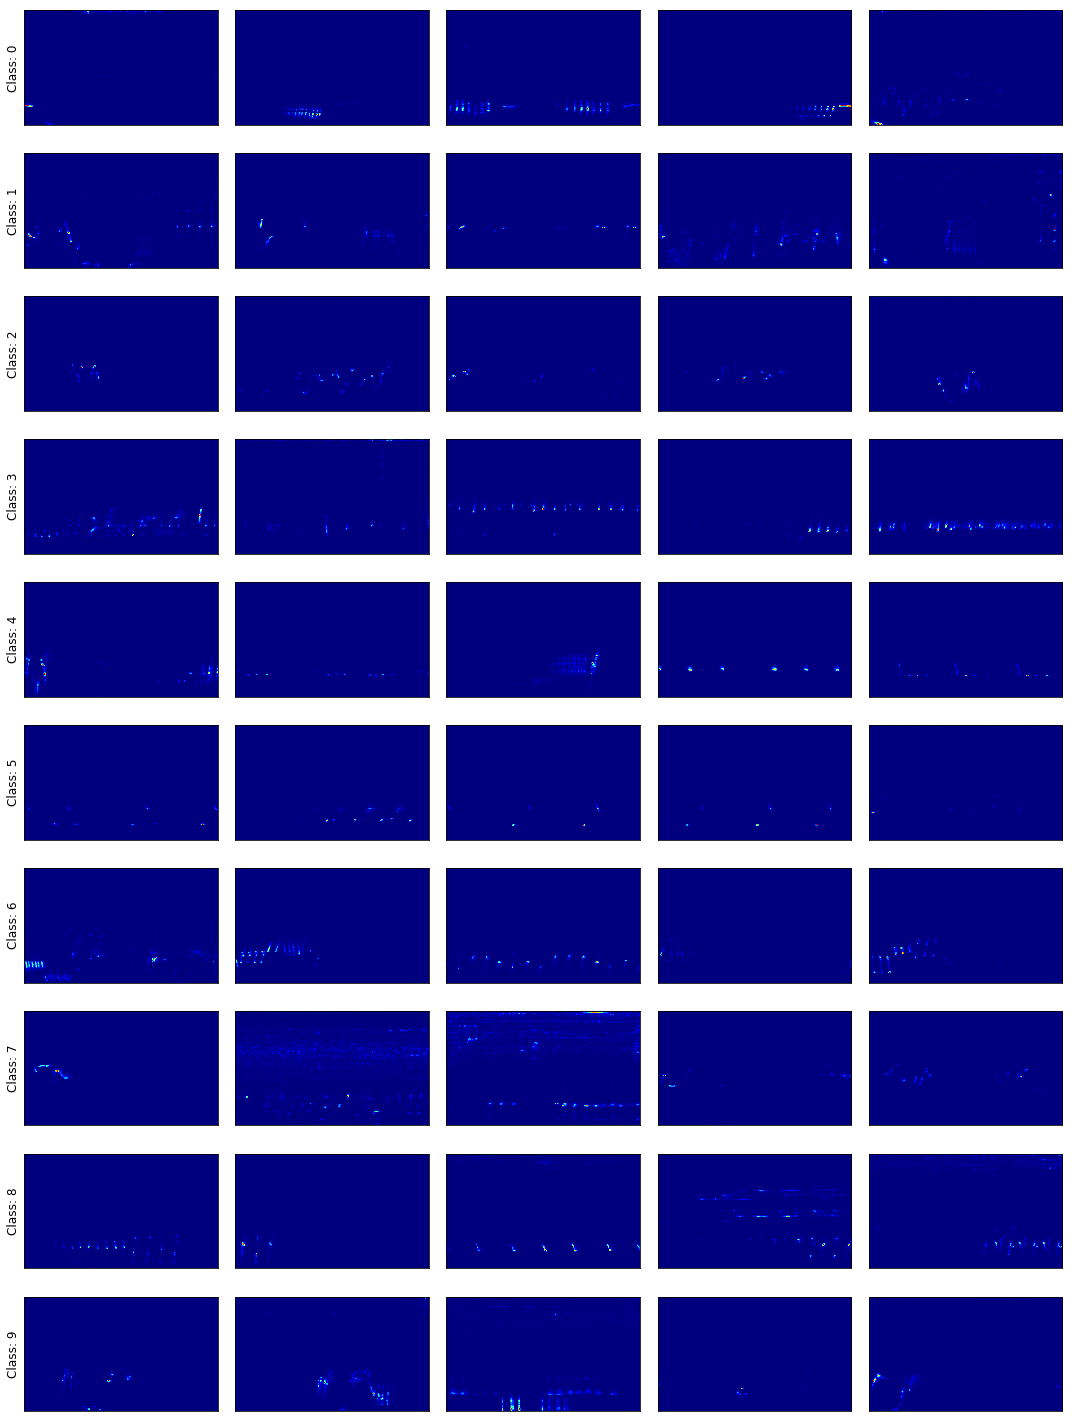

In [118]:
plot_examples(df_test)